## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [95]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from copy import deepcopy
import pandas as pd

In [2]:
%matplotlib inline

### load the dataset

In [3]:
### set your image dir here
IMAGE_DIR = "./data/"

In [15]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR, subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [23]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [24]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

./data/train/129.png


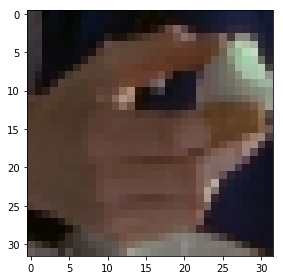

In [44]:
display(IMAGE_DIR+"train/129.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [362]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1, d)
        self.__bias = np.random.randn()
        return self.__wt, self.__bias


    def visual_wt(self):
        '''visualize the weights
        '''
        pd.DataFrame(self.__wt[0]).hist(bins=15)


    def create_batch(self, n, m):
        '''Create batches of size m or m+1
        Parameters:
            n (int): the size of data set
            m (int): the size of the batch can be either m or m+1
        Return:
            (list): a list of batches, where each batch is a list
        '''
        permute = np.random.permutation(n)
        num_m_1 = n%m            # this number of batches have size of m+1
        num_m = n//m - num_m_1   # this number of batches have size of m
        batches = []
        index = 0
        for _ in range(num_m):
            batch = []
            for _ in range(m):
                batch.append(permute[index])
                index += 1
            batches.append(batch)
        for _ in range(num_m_1):
            batch = []
            for _ in range(m+1):
                batch.append(permute[index])
                index += 1
            batches.append(batch)
        return batches


    def loss_function(self, X_bar, y, thetaT):
        '''The loss function that we want to optimize
        Parameters:
            X_bar (ndarray, n=2): the training dataset
            thetaT (ndarray, n=1): the weights
        Return:
            (float)
        '''
        summation = 0
        for Xi, yi in zip(X_bar, y):
            summation += yi * thetaT @ Xi - log(1 + exp(thetaT @ Xi))
        return -summation/len(X_bar)


    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape                              # X.shape = (8170, 324)
        self.__dimension = d

        if self.__init:
            self.__init_param()

        ### write your code here ###
        ones = np.array(np.ones(X.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_bar = np.concatenate((X, ones.T), axis=1)  # X_bar.shape  = (8170, 325), i.e already transposed
        thetaT = np.append(self.__wt[0], self.__bias)          # thetaT.shape = (325,)

        for epoch in range(1, self.__max_epoch+1):
            eta = self.__eta0/(self.__eta1 + epoch)  # eta decreases
            batches = self.create_batch(n, self.__m)
            new_thetaT = deepcopy(thetaT)
            for batch in batches:                    # batch is a list of random index
                derivative = np.zeros(len(thetaT))
                for i in range(len(batch)):
                    Xi = X_bar[batch[i]]
                    yi = y[batch[i]]
                    prob = self.sigmoid(new_thetaT @ Xi)
                    derivative += (yi - prob) * Xi
                derivative = -derivative/len(batch)             # take the average and times -1
                new_thetaT = new_thetaT - eta*derivative          # update thetaT
            loss_old = self.loss_function(X_bar, y, thetaT)
            loss_new = self.loss_function(X_bar, y, new_thetaT)
            print(epoch, loss_old, loss_new, loss_new/loss_old)
            thetaT = deepcopy(new_thetaT)

            if loss_new > (1 - self.__delta)*loss_old:   # terminate condition
                self.__wt = thetaT[0:d]
                self.__bias = thetaT[d]
                break

    def predict(self, X):
        """
        Classify the sample
        """
        ones = np.array(np.ones(X.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_bar = np.concatenate((X, ones.T), axis=1)         # X_bar.shape  = (8170, 325), i.e already transposed
        thetaT = np.append(self.__wt, self.__bias)       # thetaT.shape = (325,) # TODO, need to change dimensions here
        y_pred = []
        for Xi in X_bar:
            if self.sigmoid(thetaT @ Xi) >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return y_pred


    def save_predicts(self, y_pred):
        df_pred = pd.DataFrame(y_pred, columns=['Class'])
        index = [i for i in range(1, len(df_pred)+1)]
        df_pred.insert(0, 'Id', index)
        df_pred.to_csv('data/predTestClass.csv ', header=True, index=False)


    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias], file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias


In [363]:
lr = LogisticRegression()

In [364]:
lr.fit(X_train, y_train)

1 0.744879389798 0.674117349418 0.905002015965
2 0.674117349418 0.658053755049 0.976170922789
3 0.658053755049 0.64684696367 0.982969793436
4 0.64684696367 0.638321820409 0.986820463354
5 0.638321820409 0.631549342727 0.989390183031
6 0.631549342727 0.625962238969 0.991153337705
7 0.625962238969 0.621207199652 0.992403632326
8 0.621207199652 0.617103058997 0.993393282213
9 0.617103058997 0.613493312449 0.994150496428
10 0.613493312449 0.610284329998 0.99476932774
11 0.610284329998 0.607394411485 0.995264635891
12 0.607394411485 0.604776244439 0.995689510808
13 0.604776244439 0.602383304387 0.996043263811
14 0.602383304387 0.600184781556 0.996350292555
15 0.600184781556 0.598149538287 0.996608972217
16 0.598149538287 0.596259603816 0.996840364575
17 0.596259603816 0.594496606059 0.99704323797
18 0.594496606059 0.592845874536 0.997223312116
19 0.592845874536 0.591293377831 0.997381281085
20 0.591293377831 0.58983060977 0.997526155179
21 0.58983060977 0.58844761 0.997655259412
22 0.588447

173 0.537427230733 0.537308956429 0.999779924989
174 0.537308956429 0.537191483025 0.999781367122
175 0.537191483025 0.537074801511 0.99978279344
176 0.537074801511 0.536958894442 0.99978418822
177 0.536958894442 0.536843719988 0.999785506014
178 0.536843719988 0.53672932312 0.999786908435
179 0.53672932312 0.53661564683 0.999788205553
180 0.53661564683 0.536502728865 0.999789573849
181 0.536502728865 0.536390539936 0.999790888428
182 0.536390539936 0.536279049671 0.99979214722
183 0.536279049671 0.53616829146 0.999793469071
184 0.53616829146 0.536058204388 0.999794678137
185 0.536058204388 0.535948817523 0.999795942187
186 0.535948817523 0.535840151955 0.99979724637
187 0.535840151955 0.535732137586 0.99979842054
188 0.535732137586 0.535624785502 0.99979961612
189 0.535624785502 0.535518090891 0.999800803446
190 0.535518090891 0.535412068853 0.999802019691
191 0.535412068853 0.535306691231 0.999803184073
192 0.535306691231 0.535201943428 0.999804321889
193 0.535201943428 0.53509783639

342 0.524201134484 0.524147584299 0.999897844202
343 0.524147584299 0.524094218772 0.999898186067
344 0.524094218772 0.524041043817 0.999898539321
345 0.524041043817 0.523988040057 0.999898855709
346 0.523988040057 0.523935213101 0.999899182898
347 0.523935213101 0.523882564411 0.999899512977
348 0.523882564411 0.523830083864 0.999899823833
349 0.523830083864 0.523777780948 0.999900152897


In [365]:
y_pred = lr.predict(X_test)

In [367]:
lr.save_predicts(y_pred)

In [370]:
def save_predicts(self, y_pred):
    df_pred = pd.DataFrame(y_pred, columns=['Class'])
    index = [i for i in range(0, len(df_pred))]
    df_pred.insert(0, 'Id', index)
    df_pred.to_csv('data/predTestClass.csv ', header=True, index=False)

In [371]:
save_predicts(y_pred)

TypeError: save_predicts() missing 1 required positional argument: 'y_pred'

In [246]:
X_batch.shape

(17, 325)

In [369]:
X_test.shape

(5542, 324)

## Question 2.3

### 1. Baseline Model

In [ ]:
LR = LogisticRegression()
LR.fit(X_train,y_train)

(a) Number of epochs till termination = __

In [ ]:
# (b) Plot L(theta) vs num_epochs

(c) Final value of L($\theta$) after optimization = __

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [ ]:
# Experimentation code goes here

(a) Best value for, $\eta_0$ = \__, $\eta_1$ = \__

Number of epochs for training = __

Final value of L($\theta$) = __

In [ ]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs

### 3. Evaluating on validation set

In [ ]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure

In [ ]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure

### 4. ROC and Precision-Recall curves

In [ ]:
#(a) Plot ROC curve on validation data

Area under curve = __

In [ ]:
#(a) Plot Precision-Recall curve on validation data

In [ ]:
Average Precision = __

## Question 2.4

### 1. Submission

In [ ]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [ ]:
# code goes here

Best obtained accuracy on Public Leader-board = __%